## Now as we know optimal threshold we can try once again optimalizing stacking model

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
import joblib
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

X_train = pd.read_csv("../../datasets/merged/X_train_imputed_scaled.csv", index_col=0)
X_test = pd.read_csv("../../datasets/merged/X_test_imputed_scaled.csv",  index_col=0)
y_train = pd.read_csv("../../datasets/merged/y_train.csv", index_col=0)["label"]
y_test = pd.read_csv("../../datasets/merged/y_test.csv",  index_col=0)["label"]
groups = pd.read_csv("../../datasets/merged/groups.csv", index_col=0)["star_key"]

rf = joblib.load("../../saved-models/merged/optimal_rf.pkl")
svc = joblib.load("../../saved-models/merged/optimal_svc.pkl")

# === Stacking ===
stack = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('svc', svc)
    ],
    final_estimator=LogisticRegression(),
    stack_method='predict_proba',  # użyj soft predictions
    cv=5
)

stack.fit(X_train, y_train)

# === Predykcje i custom threshold ===
threshold = 0.35
y_proba = stack.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_proba >= threshold).astype(int)

# === Metryki ===
cm = confusion_matrix(y_test, y_pred_thresh)
prec = precision_score(y_test, y_pred_thresh)
rec = recall_score(y_test, y_pred_thresh)
f1 = f1_score(y_test, y_pred_thresh)

print("Confusion Matrix:\n", cm)
print(f"Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")


Confusion Matrix:
 [[ 979  270]
 [ 190 1209]]
Precision: 0.817, Recall: 0.864, F1: 0.840


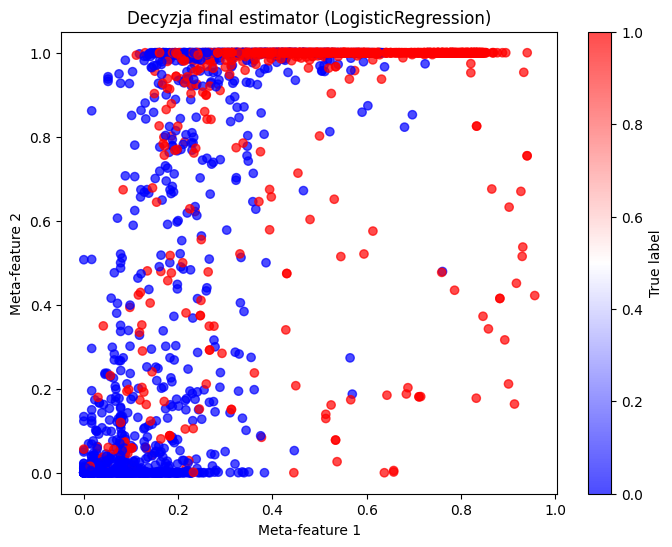

In [48]:
X_meta = stack.transform(X_test)  # to jest wejście do final estimator
y_meta_proba = stack.final_estimator_.predict_proba(X_meta)[:, 1]
joblib.dump(stack, "../../saved-models/merged/optimal_stack.pkl")

from matplotlib import pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(X_meta[:,0], X_meta[:,1], c=y_test, cmap='bwr', alpha=0.7)
plt.xlabel("Meta-feature 1")
plt.ylabel("Meta-feature 2")
plt.title("Decyzja final estimator (LogisticRegression)")
plt.colorbar(label='True label')
plt.show()


This model is the most optimal of all that i tested